* jenkspy documentation: https://github.com/mthh/jenkspy
* The dataset can be accessed through this link: https://www.kaggle.com/datasets/ilkeryildiz/online-retail-listing
* If you are a learner, you can watch my tutorial video to understand what I did: https://youtu.be/2hbL-qMTovM
* another useful tutorial post: https://pbpython.com/natural-breaks.html

In [1]:
#pip install jenkspy

In [2]:
import numpy as np
import pandas as pd
import jenkspy
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv(r"C:\Users\beytu\BAG_notebooks\Datasets\online_retail_listing.csv",
                 sep=";",
                 encoding="latin-1")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,1.12.2009 07:45,"6,95",13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,1.12.2009 07:45,"6,75",13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,1.12.2009 07:45,"6,75",13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,1.12.2009 07:45,"2,1",13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.12.2009 07:45,"1,25",13085.0,United Kingdom


In [4]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%d.%m.%Y %H:%M")
df.sort_values('InvoiceDate', ascending=True, inplace=True)

df = df.loc[df['Customer ID'].notnull()].reset_index(drop=True)

df["Price"] = df['Price'].str.replace(",", ".").astype('float64')
df["Total"] = df["Quantity"] * df["Price"]

df = df.loc[df.StockCode.str.contains('\d{5}')].reset_index(drop=True)

drop_idx = []
sub_df = df.drop_duplicates(["Customer ID", "StockCode"], keep="first")
for row in sub_df.itertuples():
    if row.Invoice.startswith('C'):
        drop_idx.append(row.Index)
        
df.drop(index=drop_idx, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

monetary = df.groupby("Customer ID")["Total"].sum().to_frame().sort_values("Total")
avg = monetary.Total.mean()
std = monetary.Total.std()
three_sigma_plus = avg + (3 * std)
monetary = monetary[(monetary.Total>=1000) & (monetary.Total<=three_sigma_plus)].round(0)

In [5]:
monetary

,Total
Customer ID,
18143.0,1000.0
14214.0,1000.0
14902.0,1000.0
15508.0,1000.0
16122.0,1001.0
...,...
15098.0,39620.0
15039.0,39743.0
17381.0,39999.0


In [6]:
monetary.Total.describe()

count     2615.000000
mean      4157.664245
std       4885.686147
min       1000.000000
25%       1506.500000
50%       2426.000000
75%       4547.000000
max      43823.000000
Name: Total, dtype: float64

In [7]:
monetary["class_qcut_3"] = pd.qcut(monetary["Total"], q=3, labels = ["low", "medium", "high"])

In [8]:
monetary['class_cut_3'] = pd.cut(monetary['Total'], bins=3, labels=['low', 'medium', 'high'])

In [9]:
monetary['class_kmeans_3'] = KMeans(n_clusters=3, random_state=False).fit_predict(monetary['Total'].to_frame())

avg_monetary = monetary.groupby('class_kmeans_3')['Total'].mean().reset_index()
mincl = avg_monetary.loc[avg_monetary.Total == avg_monetary.Total.min(), 'class_kmeans_3'].iloc[0]
maxcl = avg_monetary.loc[avg_monetary.Total == avg_monetary.Total.max(), 'class_kmeans_3'].iloc[0]
monetary['class_kmeans_3'] = monetary['class_kmeans_3'].map({mincl:'low', 
                                                             list(set(avg_monetary.class_kmeans_3.unique()) - set([mincl, maxcl]))[0]:'medium', 
                                                             maxcl:'high'})
monetary['class_kmeans_3'] = monetary['class_kmeans_3'].astype('category')

In [10]:
breaks = jenkspy.jenks_breaks(monetary['Total'], n_classes=3)
print("boundaries of classes:", breaks)

monetary['class_jenks_3'] = pd.cut(monetary['Total'], 
                                 bins=breaks, 
                                 labels=['low', 'medium', 'high'], 
                                 include_lowest=True)

boundaries of classes: [1000.0, 6264.0, 18253.0, 43823.0]


In [11]:
breaks = jenkspy.jenks_breaks(monetary['Total'], n_classes=4)
print("boundaries of classes:", breaks)

monetary['class_jenks_4'] = pd.cut(monetary['Total'], 
                                 bins=breaks, 
                                 labels=['low','medium','high','superstar'], 
                                 include_lowest=True)

boundaries of classes: [1000.0, 4243.0, 10546.0, 22101.0, 43823.0]


In [12]:
monetary

,Total,class_qcut_3,class_cut_3,class_kmeans_3,class_jenks_3,class_jenks_4
Customer ID,,,,,,
18143.0,1000.0,low,low,low,low,low
14214.0,1000.0,low,low,low,low,low
14902.0,1000.0,low,low,low,low,low
15508.0,1000.0,low,low,low,low,low
16122.0,1001.0,low,low,low,low,low
...,...,...,...,...,...,...
15098.0,39620.0,high,high,high,high,superstar
15039.0,39743.0,high,high,high,high,superstar
17381.0,39999.0,high,high,high,high,superstar


In [13]:
for i in monetary.select_dtypes(include='category').columns:
    display(monetary.groupby(i, sort=False)['Total'].agg({"count", "min", "max"})[["count", "min", "max"]])

,count,min,max
class_qcut_3,,,
low,872,1000.0,1737.0
medium,871,1738.0,3613.0
high,872,3615.0,43823.0


,count,min,max
class_cut_3,,,
low,2509,1000.0,14921.0
medium,88,15353.0,29526.0
high,18,30392.0,43823.0


,count,min,max
class_kmeans_3,,,
low,2190,1000.0,6350.0
medium,360,6366.0,18253.0
high,65,18716.0,43823.0


,count,min,max
class_jenks_3,,,
low,2181,1000.0,6264.0
medium,369,6304.0,18253.0
high,65,18716.0,43823.0


,count,min,max
class_jenks_4,,,
low,1885,1000.0,4243.0
medium,532,4257.0,10546.0
high,156,10611.0,22101.0
superstar,42,22618.0,43823.0


In [14]:
jnb = jenkspy.JenksNaturalBreaks(4)

jnb.fit(monetary.Total.values)

print(jnb.labels_) # Labels for fitted data
#print(jnb.groups_) # Content of each group
print(jnb.breaks_) # Break values (including min and max)
print(jnb.inner_breaks_) # Inner breaks (ie breaks_[1:-1])

[0 0 0 ... 3 3 3]
[1000.0, 4243.0, 10546.0, 22101.0, 43823.0]
[4243.0, 10546.0, 22101.0]


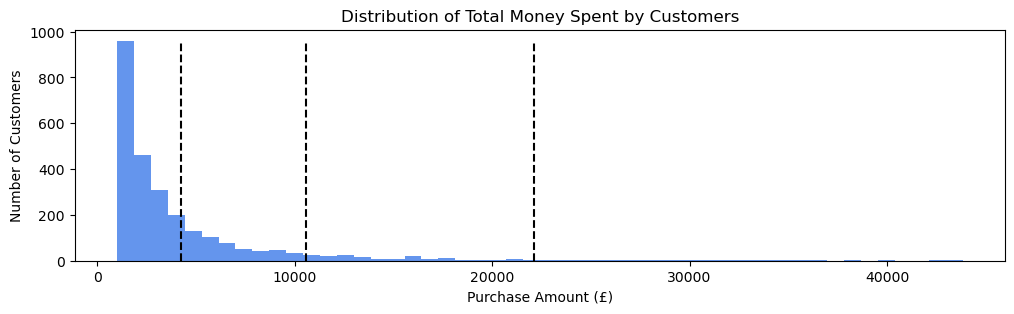

In [15]:
fig, ax = plt.subplots(figsize=(12, 3))

# Set title and labels for axes
ax.set(xlabel="Purchase Amount (£)",
       ylabel="Number of Customers",
       title="Distribution of Total Money Spent by Customers")

hist = plt.hist(monetary['Total'], bins=50, color='cornflowerblue')
for b in jnb.inner_breaks_:
    plt.vlines(b, ymin=0, ymax=max(hist[0]), color='black', ls='--')

In [16]:
jnb.predict(28000)   # predict the group of a value

array(3)

In [17]:
jnb.predict([8937, 17012, 2693, 42770, 3821, 11532, 24173])   # predict the group of several values

array([1, 2, 0, 3, 0, 2, 3])

In [18]:
jnb.group([8937, 17012, 2693, 42770, 3821, 11532, 24173])   # group the elements into these groups

[array([2693, 3821]),
 array([8937]),
 array([17012, 11532]),
 array([42770, 24173])]